In [328]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
from scipy import signal
import matplotlib.pyplot as plt
from mne.decoding import CSP
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP



In [329]:
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

In [330]:
# #運動実行と運動想起+運動実行の比較
# day1_movement_data = np.load('numpy_data/subject3_motor_data1.npy')
# day2_movement_data = np.load('numpy_data/subject3_motor_data2.npy')
# day1_imageMove_data = np.load('numpy_data/subject3_data1.npy')
# day2_imageMove_data = np.load('numpy_data/subject3_data2.npy')

# brain_data = np.vstack([day1_movement_data,day2_movement_data,
# day1_imageMove_data[0:60],day2_imageMove_data[0:60]])
# #labelデータの作成
# class_label = np.zeros(240,dtype=int)
# class_label[120:] = 1

In [331]:
#運動想起＋運動実行のタスクごとの比較
day1_movement_data = np.load('numpy_data/subject3_data1_extension.npy')
day2_movement_data = np.load('numpy_data/subject3_data2_extension.npy')
day1_imageMove_data = np.load('numpy_data/subject3_data1_flexion.npy')
day2_imageMove_data = np.load('numpy_data/subject3_data2_flexion.npy')

brain_data = np.vstack([day1_movement_data,day2_movement_data,
day1_imageMove_data,day2_imageMove_data])
# brain_data = scipy.stats.zscore(brain_data)


#labelデータの作成
class_label = np.zeros(240,dtype=int)
class_label[120:] = 1

In [332]:
n_channels = 64
sampling_freq = 100  # in Hertz
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=sampling_freq)
info.set_montage('standard_1020')

events = np.column_stack(
    (
        np.arange(0, 100*240, sampling_freq),
        np.zeros(240, dtype=int),
        class_label
    )
)
event_dict = dict(condition_A=0, condition_B=1)
simulated_epochs = mne.EpochsArray(
    brain_data, info, tmin=-6, events=events, event_id=event_dict,baseline=(-6,-3)
)

Not setting metadata
240 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [333]:
simulated_epochs = simulated_epochs.filter(l_freq=2.0,h_freq=30)


Setting up band-pass filter from 2 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 15360 out of 15360 | elapsed:    1.3s finished


In [334]:
onlyMove_epochs = simulated_epochs["condition_A"]
imageMove_epochs = simulated_epochs["condition_B"]

combining channels using "gfp"
combining channels using "gfp"


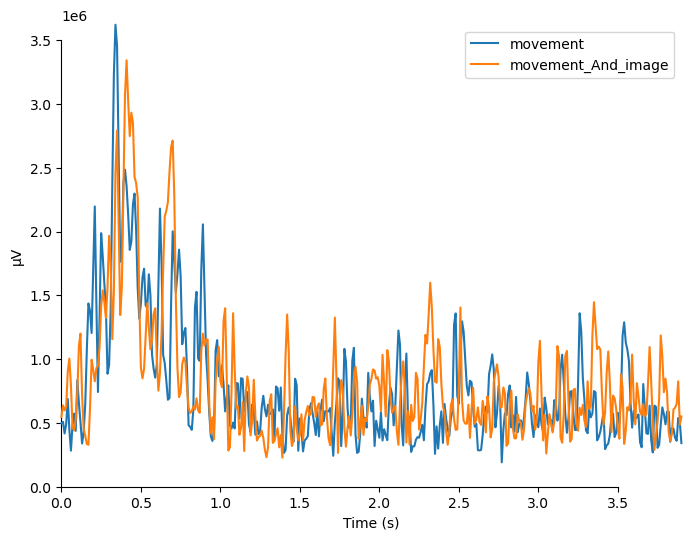

[<Figure size 800x600 with 1 Axes>]

In [335]:
onlyMove_evoked = onlyMove_epochs.average().crop(tmin=0, tmax=3.9, include_tmax=True)
imageMove_evoked = imageMove_epochs.average().crop(tmin=0, tmax=3.9, include_tmax=True)

mne.viz.plot_compare_evokeds(
    dict(movement=onlyMove_evoked, movement_And_image=imageMove_evoked),
    legend="upper right"
)

In [336]:
onlyMove_psd = onlyMove_evoked.compute_psd(fmin=0.0, fmax=31.0)
imageANDmove_psd = imageMove_evoked.compute_psd(fmin=0.0, fmax=31.0)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [337]:
test = onlyMove_psd.get_data()

In [338]:
motor_brainAdress = [9,10,11,12,13,17,18,31,44,45,46,47,48,49,50,54,55]

sample1 = onlyMove_psd.get_data()
sample2 = imageANDmove_psd.get_data()
sample1 = sample1[motor_brainAdress]
sample2 = sample2[motor_brainAdress]
sample1 = sample1.mean(axis = 0)
sample2 = sample2.mean(axis = 0)
f = np.linspace(0,31,122)

In [339]:
sample1 = 10*np.log10(sample1)
sample2 = 10*np.log10(sample2)

(0.0, 30.0)

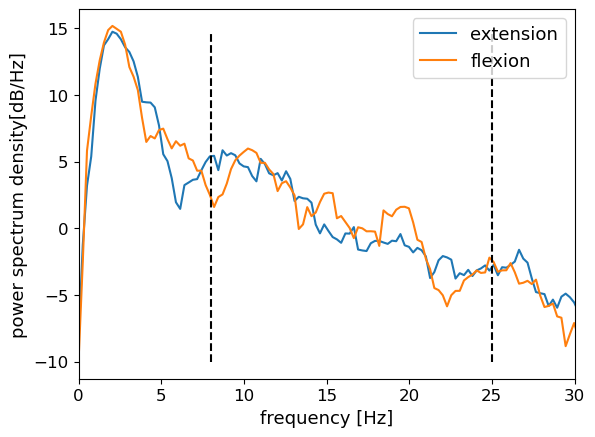

In [340]:
Figure, ax = plt.subplots() #グラフオブジェクトを生成

# ax.plot(f,sample1,label = "movement")
# ax.plot(f,sample2,label = "movement+Image")
ax.plot(f,sample1,label = "extension")
ax.plot(f,sample2,label = "flexion")
ax.legend(fontsize = 13)
plt.vlines(8,sample2.min(),sample1.max(),"black",linestyles = 'dashed')
plt.vlines(25,sample2.min(),sample1.max(),"black",linestyles = 'dashed')
plt.xlabel("frequency [Hz]",fontsize = 13)
plt.ylabel("power spectrum density[dB/Hz]",fontsize = 13)
plt.tick_params(labelsize = 12)
ax.set_xlim(0,30)

In [341]:
onlyMove_evo = onlyMove_evoked.get_data().mean(axis = 0)
imageMove_evo = imageMove_evoked.get_data().mean(axis = 0)

np.shape(onlyMove_evo)
N =391
fs = 100
time = np.linspace(0,3.9,391)

(0.0, 25.0)

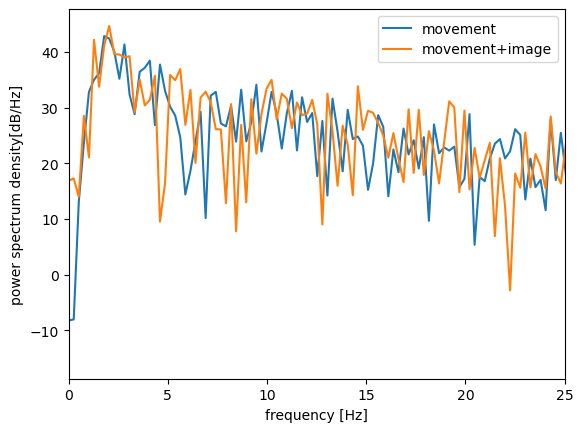

In [342]:
from scipy.fft import rfft,rfftfreq
rfft_data = rfft(onlyMove_evo)
rfft_as = np.abs(rfft_data)
rfft_freq = rfftfreq(len(onlyMove_evo), d=1.0/fs)
rfft_ps = pow(rfft_as, 2)
rfft_ps = pow(rfft_as, 2)
delta_f = fs / N
rfft_psd = rfft_ps / delta_f
rfft_psd_db = 10 * np.log10(rfft_psd)

rfft_data1 = rfft(imageMove_evo)
rfft_as1 = np.abs(rfft_data1)
rfft_freq1 = rfftfreq(len(imageMove_evo), d=1.0/fs)
rfft_ps1 = pow(rfft_as1, 2)
rfft_ps1 = pow(rfft_as1, 2)
delta_f1 = fs / N
rfft_psd1 = rfft_ps1 / delta_f1
rfft_psd_db1 = 10 * np.log10(rfft_psd1)



Figure, ax = plt.subplots() #グラフオブジェクトを生成

ax.plot(rfft_freq, rfft_psd_db,label = 'movement')
ax.plot(rfft_freq1, rfft_psd_db1,label = 'movement+image')
ax.legend()
plt.xlabel("frequency [Hz]")
plt.ylabel("power spectrum density[dB/Hz]")
ax.set_xlim(0,25)

/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/Users/yaman/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


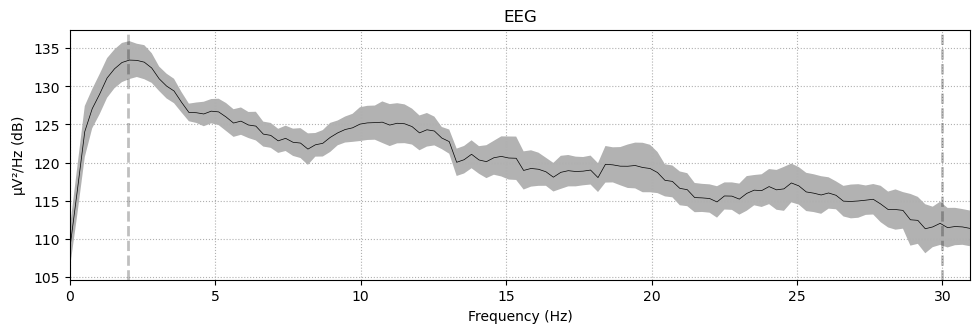

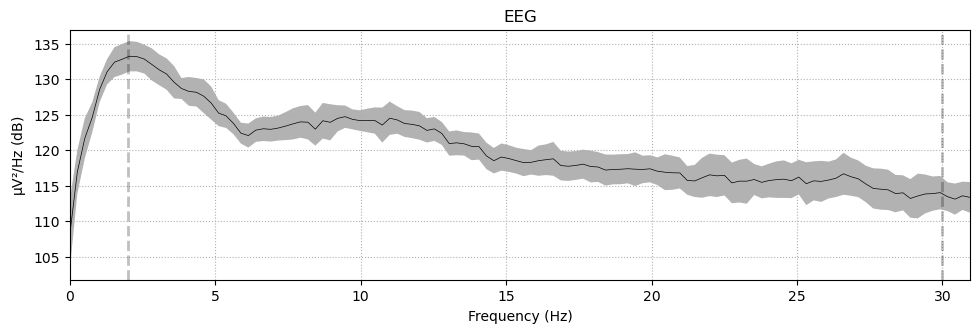

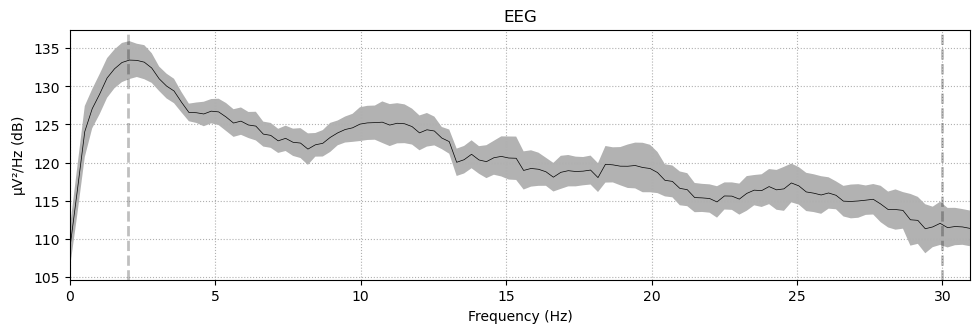

In [343]:
onlyMove_psd.plot(average=True, picks="data", exclude="bads")
imageANDmove_psd.plot(average=True, picks="data", exclude="bads")

In [344]:
onlyMove_evoked_num = onlyMove_evoked.get_data()
imageMove_evoked_num = imageMove_evoked.get_data()
onlyMove_ave = onlyMove_evoked_num.mean(axis = 0)
imageMove_ave = imageMove_evoked_num.mean(axis = 0)

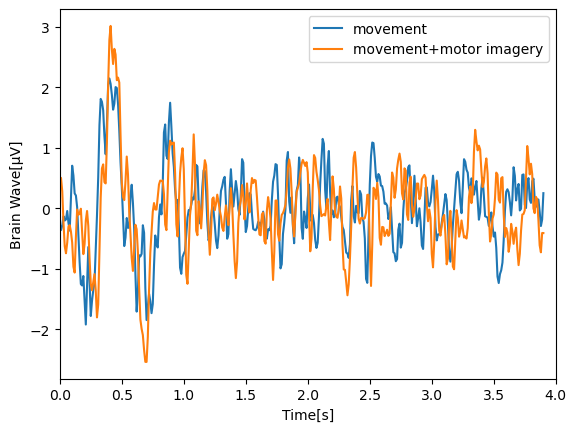

In [345]:
t = np.linspace(0, 3.9,391)

Figure, ax = plt.subplots() #グラフオブジェクトを生成
plt.xlabel("Time[s]")
plt.ylabel("Brain Wave[μV]")
ax.set_xlim(0,4)
ax.plot(t,onlyMove_ave,label = "movement")
ax.plot(t,imageMove_ave,label = "movement+motor imagery")
ax.legend()

In [346]:
F1 = np.fft.fft(onlyMove_ave)
freq1 = np.fft.fftfreq(391,1/100)
F1 = F1/(391/2)
amp1 = np.abs(F1)
#plt.plot(freq1[:120],amp1[:120])

F2 = np.fft.fft(imageMove_ave)
freq2 = np.fft.fftfreq(391,1/100)
F2 = F2/(391/2)
amp2 = np.abs(F2)
#plt.plot(freq2[:120],amp2[:120])

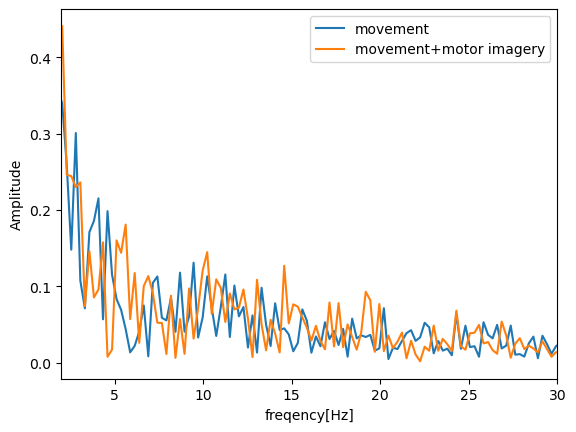

In [347]:
Figure, bx = plt.subplots() #グラフオブジェクトを生成
plt.xlabel("freqency[Hz]")
plt.ylabel("Amplitude")
bx.set_xlim(2,30)
bx.plot(freq1[:120],amp1[:120],label = "movement")
bx.plot(freq2[:120],amp2[:120],label = "movement+motor imagery")
bx.legend()
plt.show()

In [348]:
import math

In [349]:
bar_theta = amp1[16:32].sum()
bar_alpha = amp1[33:48].sum()
bar_beta = amp1[49:102].sum()
print(bar_theta,bar_alpha,bar_beta)

1.2741301666965872 1.0873121278731905 1.83554012755467


In [350]:
bar_theta2 = amp2[16:32].sum()
bar_alpha2 = amp2[33:48].sum()
bar_beta2 = amp2[49:102].sum()
print(bar_theta2,bar_alpha2,bar_beta2)

1.385305788823977 1.0985823489780904 2.124277260445209
